In [1]:
import sys
sys.path.insert(0, '/well/rahimi/users/sev854/project/EHRPretrain/EHRPretraining')

from utils.yaml_act import yaml_load, yaml_save
from utils.arg_parse import arg_paser
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
from pytorch_lightning.callbacks import LearningRateMonitor
from model import CPC
from lifelines import CoxPHFitter
import seaborn as sns

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

# Global functions

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
from preprocess import transform
from torchvision import transforms
import pandas as pd
import numpy as np


class EHR2VecDset(Dataset):
    def __init__(self, dataset, params):
        # dataframe preproecssing
        # filter out the patient with number of visits less than min_visit
        self.data = dataset
        self._compose = transforms.Compose([
            transform.TruncateSeqence(params['max_seq_length']),
            transform.CreateSegandPosition(),
            transform.TokenAgeSegPosition2idx(params['token_dict_path'], params['age_dict_path']),
            transform.RetriveSeqLengthAndPadding(params['max_seq_length']),
            transform.FormatAttentionMask(params['max_seq_length']),
        ])

    def __getitem__(self, index):
        """
        return: age, code, position, segmentation, mask, label
        """
        patid = self.data.patid[index]
        sample = {
            'code': self.data.code[index],
            'age': self.data.age[index],
#             'event': self.data.event[index],
#             'time': self.data.time[index],
            # 'label': self.data.label[index]
        }

        sample = self._compose(sample)

        return {'patid': torch.LongTensor([int(patid)]),
                'code': torch.LongTensor(sample['code']),
                'age': torch.LongTensor(sample['age']),
                'att_mask': torch.LongTensor(sample['att_mask']),
#                 'event': torch.FloatTensor([sample['event']]),
#                 'time': torch.FloatTensor([sample['time']]),
                'len': torch.LongTensor([sample['len']])
                }

    def __len__(self):
        return len(self.data)


def CPCDataLoader(params, data, batch_size, shuffle=True):
    print('data size:', len(data))
    dset = EHR2VecDset(dataset=data, params=params)
    dataloader = DataLoader(dataset=dset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=params['num_workers'],
                            )
    return dataloader

In [4]:
class Model(CPC):
    def __init__(self, params):
        super().__init__(params)
        
    def load_weight(self, check_point, load_module):
        pretrained_dict = torch.load(check_point,map_location=lambda storage, loc: storage)['state_dict']
        model_dict = self.state_dict()

        print('incompatible keys: ', {k for k, v in pretrained_dict.items() if k not in model_dict})

        if load_module:
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                               k in model_dict and model_dict[k].shape == v.shape and any(nd in k for nd in load_module)}
        else:
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                               k in model_dict and model_dict[k].shape == v.shape}

        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)
    
    def forward(self, batch):
        z = self.embedding(batch['code'], batch['age'])
        size = z.size()[0]
        hidden = self.init_hidden(size)
        output, hidden = self.gru(z, hidden)
        
        cache_out = torch.empty(size, self.params['hidden_size'], device=self.device) # batch * hidden_size
        seq_len = batch['len'] # [batch, 1]
        
        for i in np.arange(size):
            cache_out[i] = output[i, seq_len[i].view(-1)-1].view(self.params['hidden_size'])
        
        return cache_out
    
    def reset_buffer(self):
        self.patid = []
        self.rep = []
        
    def on_test_epoch_start(self) -> None:
        self.reset_buffer()
    
    def test_step(self, batch, batch_idx):
        h = self.forward(batch)
        self.rep.append(h.cpu())
        self.patid.append(batch['patid'].cpu())

    def test_epoch_end(self, outs):
        patid = torch.cat(self.patid, dim=0).view(-1).numpy()
        rep = torch.cat(self.rep, dim=0).view(-1, self.params['hidden_size']).numpy()
        np.savez(os.path.join(self.params['save_path'], 'result.npz'), rep=rep, patid=patid)

# Load Files

In [5]:
params = yaml_load('/well/rahimi/users/sev854/project/EHRPretrain/log/pretrain/config.yaml')
data = pd.read_parquet('/well/rahimi/users/sev854/project/EHRPretrain/data/BEHRT_evaluation_1.parquet/').reset_index(drop=True)
save_path = '/well/rahimi/users/sev854/project/EHRPretrain/log/pretrain/evaluation'
model_path = '/well/rahimi/users/sev854/project/EHRPretrain/log/pretrain/last.ckpt'

if not os.path.exists(save_path):
    os.makedirs(save_path)

/well/rahimi/users/sev854/project/EHRPretrain/EHRPretraining/utils/yaml_act.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = yaml.load(ymlfile)


# Extract set up files

In [6]:
env_params, base_params, train_params,  callback_params = \
    params['env_params'], params['base_params'], \
    params['train_params'], params['callback_params']

# Load dataset

In [7]:
train_params.update(base_params['dataloader_params'])
dataloader =CPCDataLoader(params=train_params, data=data, batch_size=512, shuffle=False)

data size: 53003


# model

In [8]:
model_params = base_params['model_params']
model_params.update(base_params['dataloader_params'])
model_params.update({'save_path': save_path})
model_params.update({'checkpoint_feature': os.path.join(save_path, 'save_ckpt.ckpt')})

model = Model(model_params)
model.load_weight(model_path, None)

incompatible keys:  set()


In [8]:
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
trainer.test(model, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.62it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

# Load representation

In [9]:
result = np.load(os.path.join(save_path, 'result.npz'))

# K-means

In [11]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn_pandas import DataFrameMapper
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import math
import scipy
import seaborn as sns

In [12]:
# inertias = []
# K = range(2, 40)

# train = result['rep']

# for k in K:
#     if k%5==0:
#         print(k) 
#     # Building and fitting the model
#     kmeanModel = KMeans(n_clusters=k).fit(train)
#     inertias.append(kmeanModel.inertia_)
    
# plt.plot(K, inertias, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Inertia')
# plt.title('The Elbow Method using Inertia')
# plt.show()

In [16]:
n=10

In [11]:

train = result['rep']
kmeanModel = KMeans(n_clusters=n).fit(train)

In [12]:
tsne=TSNE(n_components=2, learning_rate='auto', init='random')
X_embedded = tsne.fit_transform(train)
plot_df = pd.DataFrame({'X1': X_embedded[:, 0], 'X2': X_embedded[:, 1], 'cluster': kmeanModel.labels_})

In [11]:
palette = sns.color_palette("Paired", 10)

<AxesSubplot:xlabel='X1', ylabel='X2'>

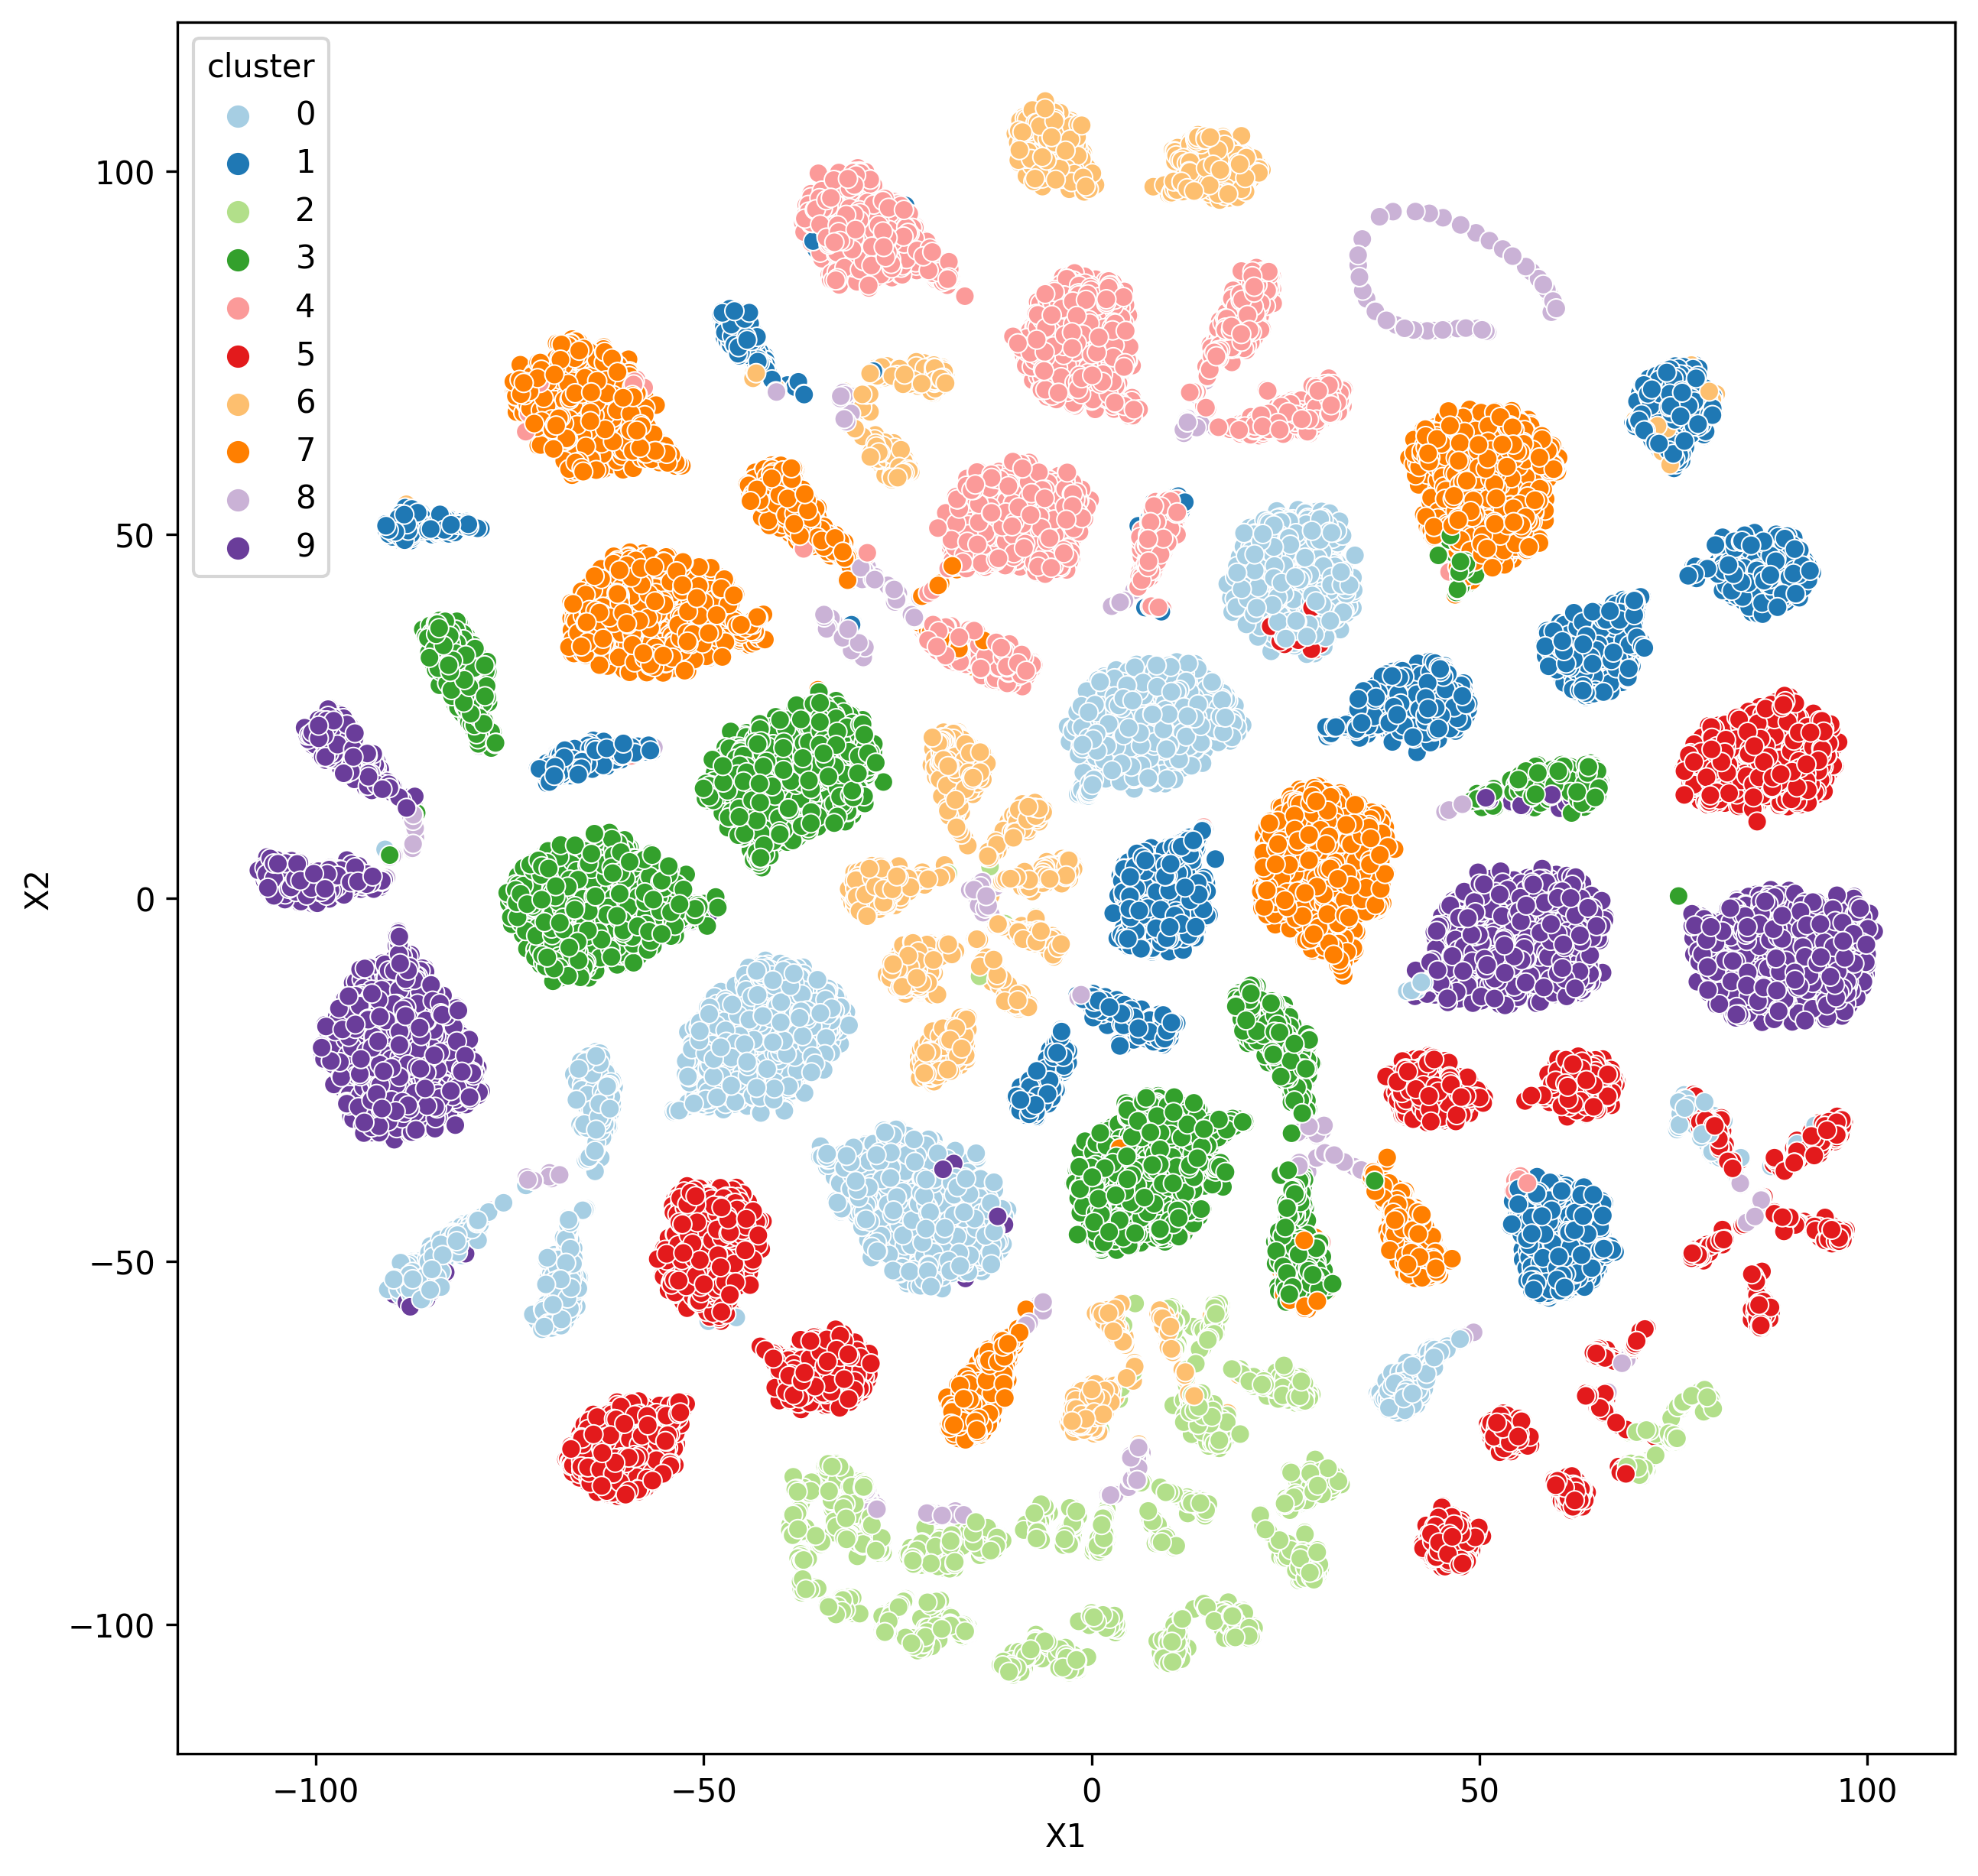

In [13]:
plt.figure(figsize=(10,10), dpi=300)
# palette = sns.color_palette("Paired", 10)
sns.scatterplot(data=plot_df, x="X1", y="X2", hue="cluster", palette=palette, legend='full')

In [14]:
data['label'] = kmeanModel.labels_

In [19]:
# data.to_parquet(os.path.join(save_path, 'result.parquet'))

In [12]:
data = pd.read_parquet(os.path.join(save_path, 'result.parquet'))

# pie chart

([<matplotlib.patches.Wedge at 0x2b906832df10>,
 [Text(1.0011131003600164, 0.4558207545598992, 'cluster 0'),
  Text(0.39468898031759797, 1.026752457418951, 'cluster 1'),
  Text(-0.2151604386048058, 1.0787520501298655, 'cluster 2'),
  Text(-0.7918811395644617, 0.7634947680253543, 'cluster 3'),
  Text(-1.0962150385641567, 0.0911734019645251, 'cluster 4'),
  Text(-0.9214154530355763, -0.600827398599002, 'cluster 5'),
  Text(-0.3982264779884077, -1.0253856212318118, 'cluster 6'),
  Text(0.3218853541450917, -1.0518506637288818, 'cluster 7'),
  Text(0.7917449821072615, -0.7636359625554392, 'cluster 8'),
  Text(1.0380277049689446, -0.3640034116830581, 'cluster 9')],
 [Text(0.5460616911054634, 0.2486295024872177, '13.6%'),
  Text(0.2152848983550534, 0.5600467949557915, '11.1%'),
  Text(-0.11736023923898496, 0.5884102091617447, '6.8%'),
  Text(-0.43193516703516094, 0.4164516916501932, '12.5%'),
  Text(-0.597935475580449, 0.049730946526104595, '9.3%'),
  Text(-0.5025902471103143, -0.327724035599

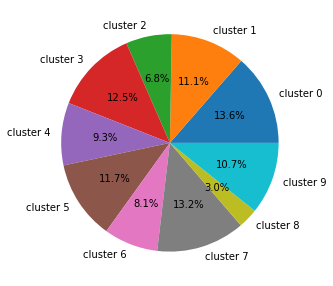

In [18]:
label = range(n)
plt.figure(figsize=(5,5))
pat_len = []
labels = []
for each in label:
    pat_len.append(len(data[data['label']==each]))
    labels.append('cluster {}'.format(each))
plt.pie(x=pat_len, autopct="%.1f%%", labels=labels)

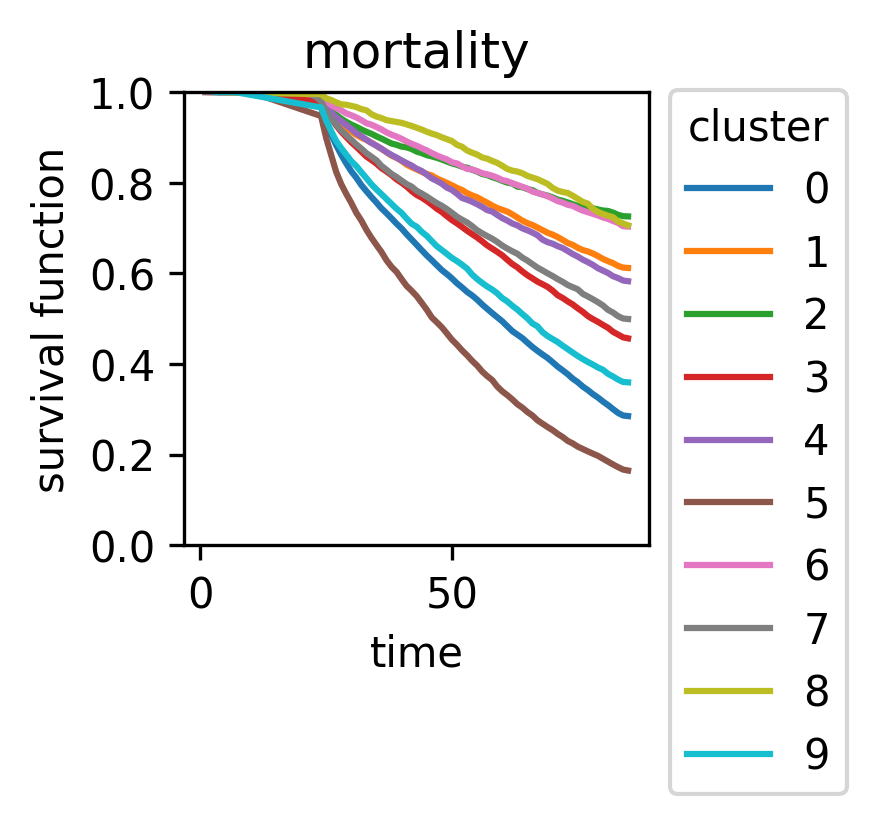

In [20]:
# label = [0, 3]

fig = plt.figure(figsize=(2,2), dpi=300)
plot_ax = {}

task_list = ['mortality']

task_map = {
    'mortality': ['event', 'time'],
}

for i, task in enumerate(task_list):
#     print(task)
    plot_ax[i] = fig.add_subplot(int('11{}'.format(i+1)))
    
    for each in label:
        train = data[data['label']==each].reset_index(drop=True)[['patid'] + [task_map[task][0], task_map[task][1]]]

#         print('group {}, number of patient: {}'.format(each, len(train)))
        cph = CoxPHFitter().fit(train, task_map[task][1], task_map[task][0])
        surv = cph.baseline_survival_
        plot_ax[i].plot(surv.index.values, surv.values, '-',label=each)
#     plot_ax[i].legend(title='cluster')
    plot_ax[i].set_title(task)
    plot_ax[i].set_ylim(0, 1)
    plot_ax[i].set_ylabel('survival function')
    plot_ax[i].set_xlabel('time')
    plot_ax[i].legend(title='cluster', bbox_to_anchor=(1., 1.05))

plt.show()

Text(0.5, 99.66666666666667, 'cluster')

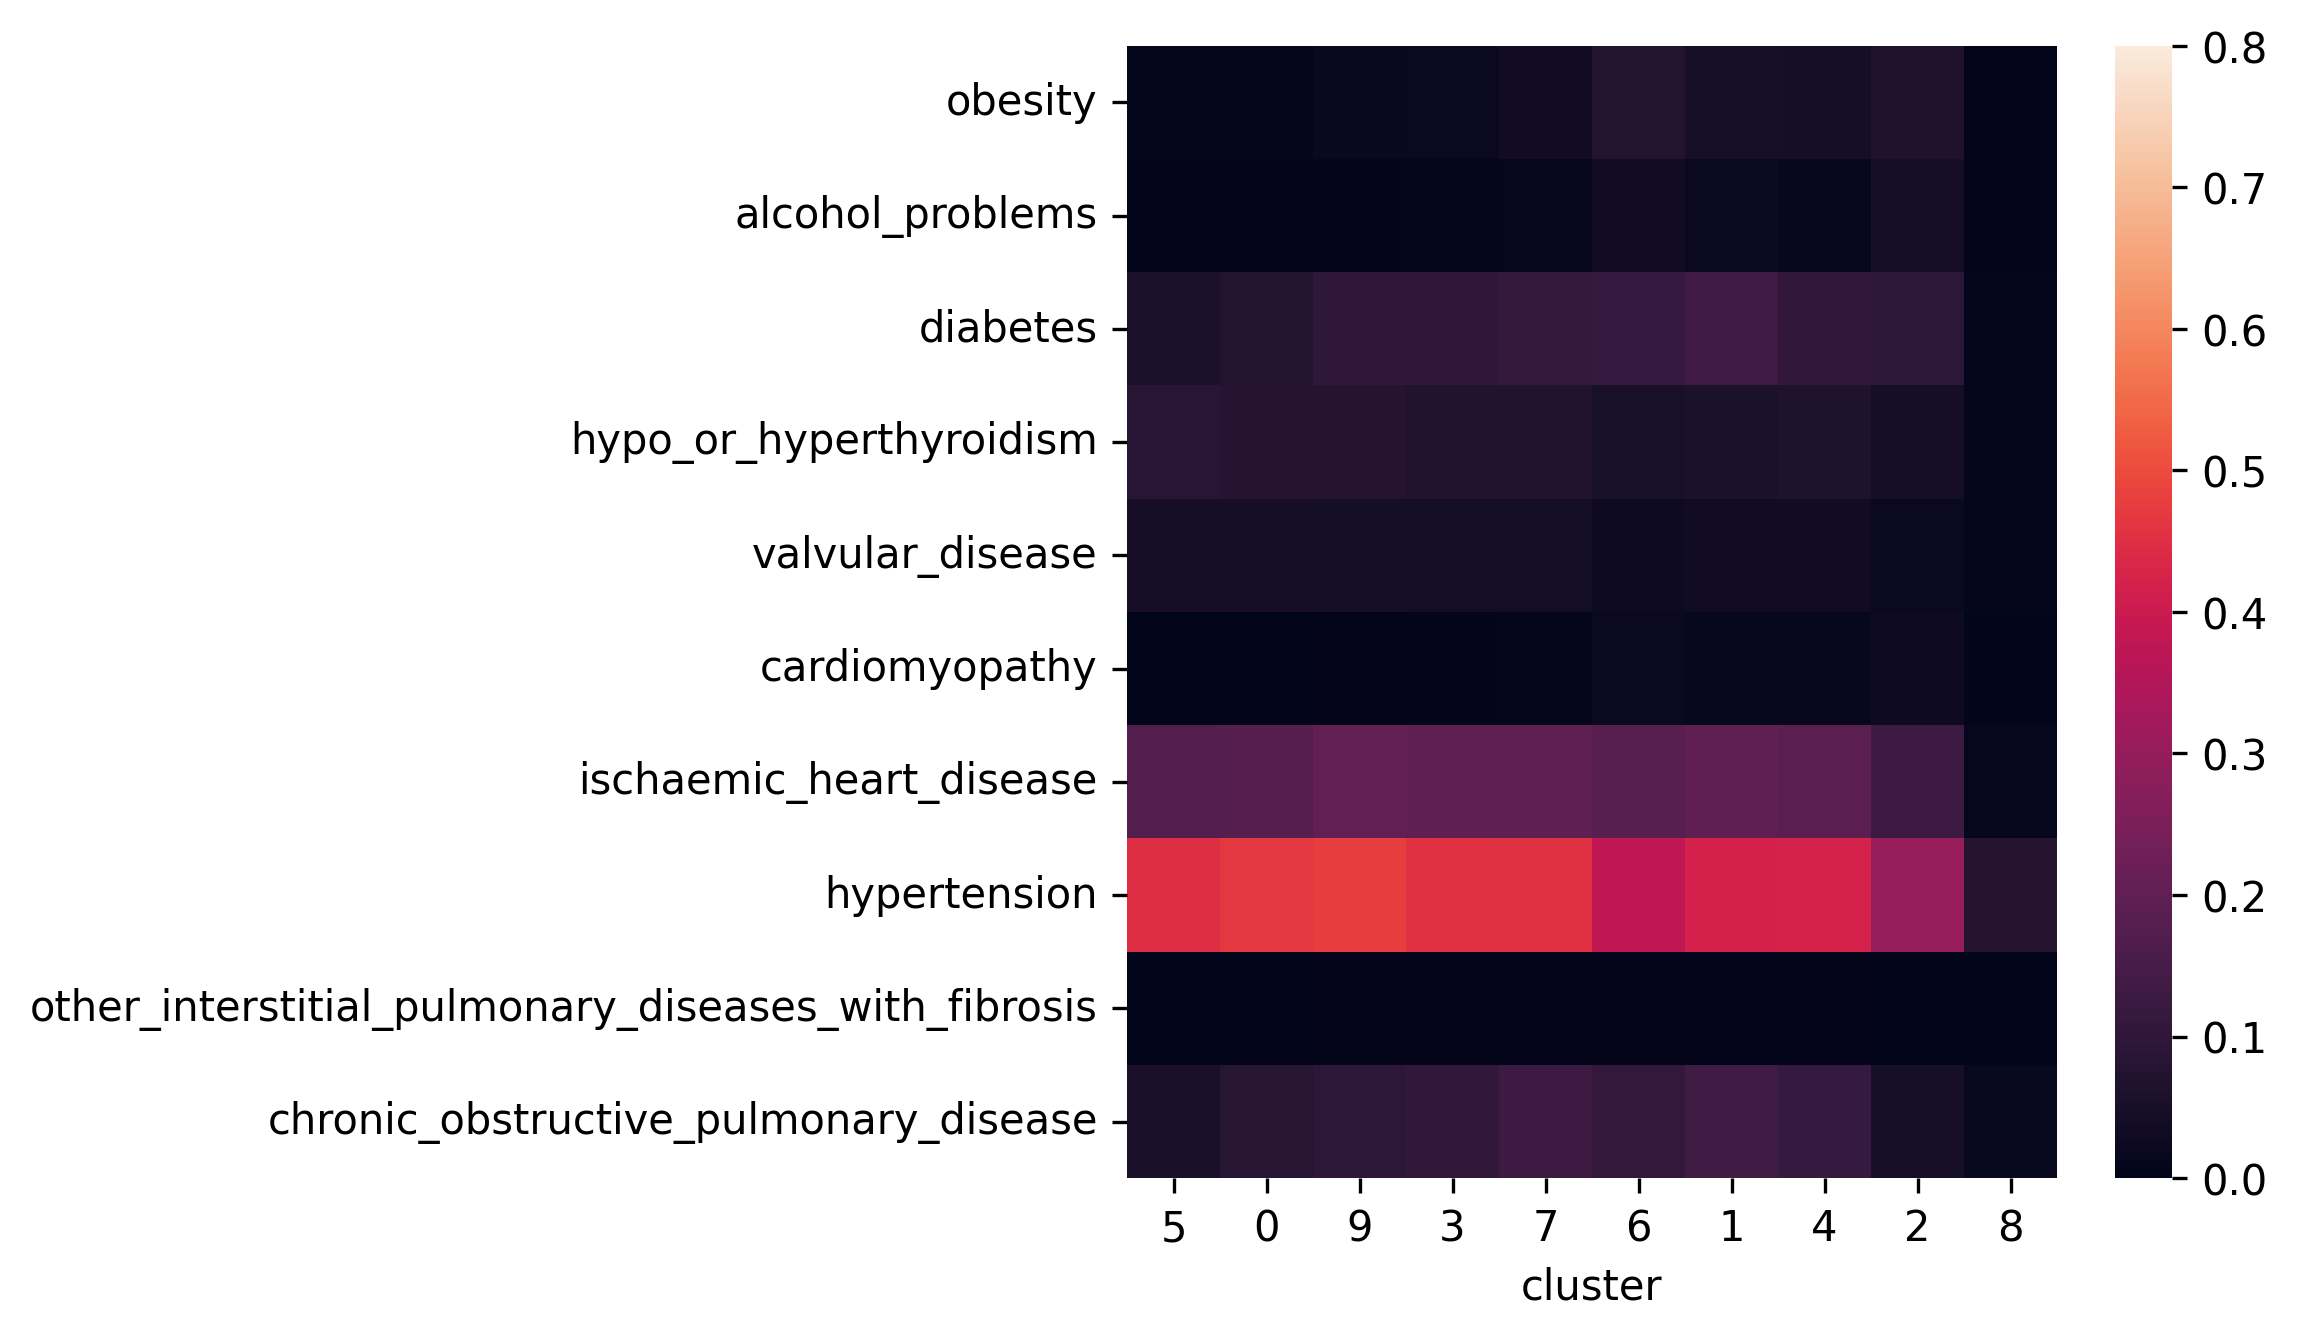

In [17]:
data = data.dropna()
label = [5, 0, 9, 3, 7, 6, 1, 4, 2, 8]

feature = ['obesity', 'alcohol problems', 'diabetes', 'hypo or hyperthyroidism',
          'valvular disease', 'cardiomyopathy', 'ischaemic heart disease',
          'hypertension', 'other interstitial pulmonary diseases with fibrosis', 'chronic obstructive pulmonary disease']

feature = ['_'.join(each.split()) for each in feature]

co_matrix = []

for cluster in label:
    prev = []
    tmp = data[data['label']==cluster]
    for col in feature:
        des = tmp[col].values
        prev.append(sum(des)/len(des))
    co_matrix.append(prev)

# co prevalence matrix with row as group and col as feature
co_matrix = np.transpose(np.array(co_matrix))

plt.figure(figsize=(5,5), dpi=300)
sns.heatmap(co_matrix, xticklabels=[str(each) for each in label], yticklabels=feature, vmin=0, vmax=0.8)
plt.xlabel('cluster')

# 1-year records after the HF

In [18]:
rec = pd.read_parquet('/well/rahimi/users/sev854/project/EHRPretrain/data/hf_records_one_year_v1.parquet')
prod = pd.read_table('/well/rahimi/users/sev854/project/EHRPretrain/data/product.txt', encoding='ISO-8859-1')[['prodcode', 'productname']]
prod = prod.set_index('prodcode').T.to_dict('records')[0]
cohort = data[['patid', 'label']]
cohort = cohort.merge(rec, on='patid', how='left')
top_n = 10

In [19]:
# medication
def keep_identical(x, prefix):
    mp = set()
    for each in x:
        if each[0:3] == prefix:
            mp.add(each[3:])
    return list(mp)

med_df = []

for cluster in label:
    tmp = cohort[cohort['label']==cluster]
    tmp = tmp.dropna()
    n = len(tmp) # patient number
    tmp['code'] = tmp.code.apply(lambda x: keep_identical(x, 'MED'))
    tmp = tmp.explode('code')
    cnt = tmp.code.value_counts()
    name = [prod[int(each)] for each in cnt.index.values]
    cnt = [round(each, 2) for each in cnt.values/n]
    top = list(zip(name[0:top_n], cnt[0:top_n]))
    med_df.append(pd.DataFrame({'cluster': [cluster], 'top medication': [top]}))

med_df = pd.concat(med_df)
med_name = {}

for name in med_df.explode('top medication')['top medication'].apply(lambda x: x[0]).unique():
    med_name[name] = np.zeros(len(label))

for cluster in label:
    for name, prev in med_df[med_df['cluster']==cluster]['top medication'].values[0]:
        med_name[name][cluster] = prev
        
med_prev = pd.DataFrame(med_name).T

In [22]:
med_prev = med_prev[label]

Text(0.5, 174.66666666666669, 'cluster')

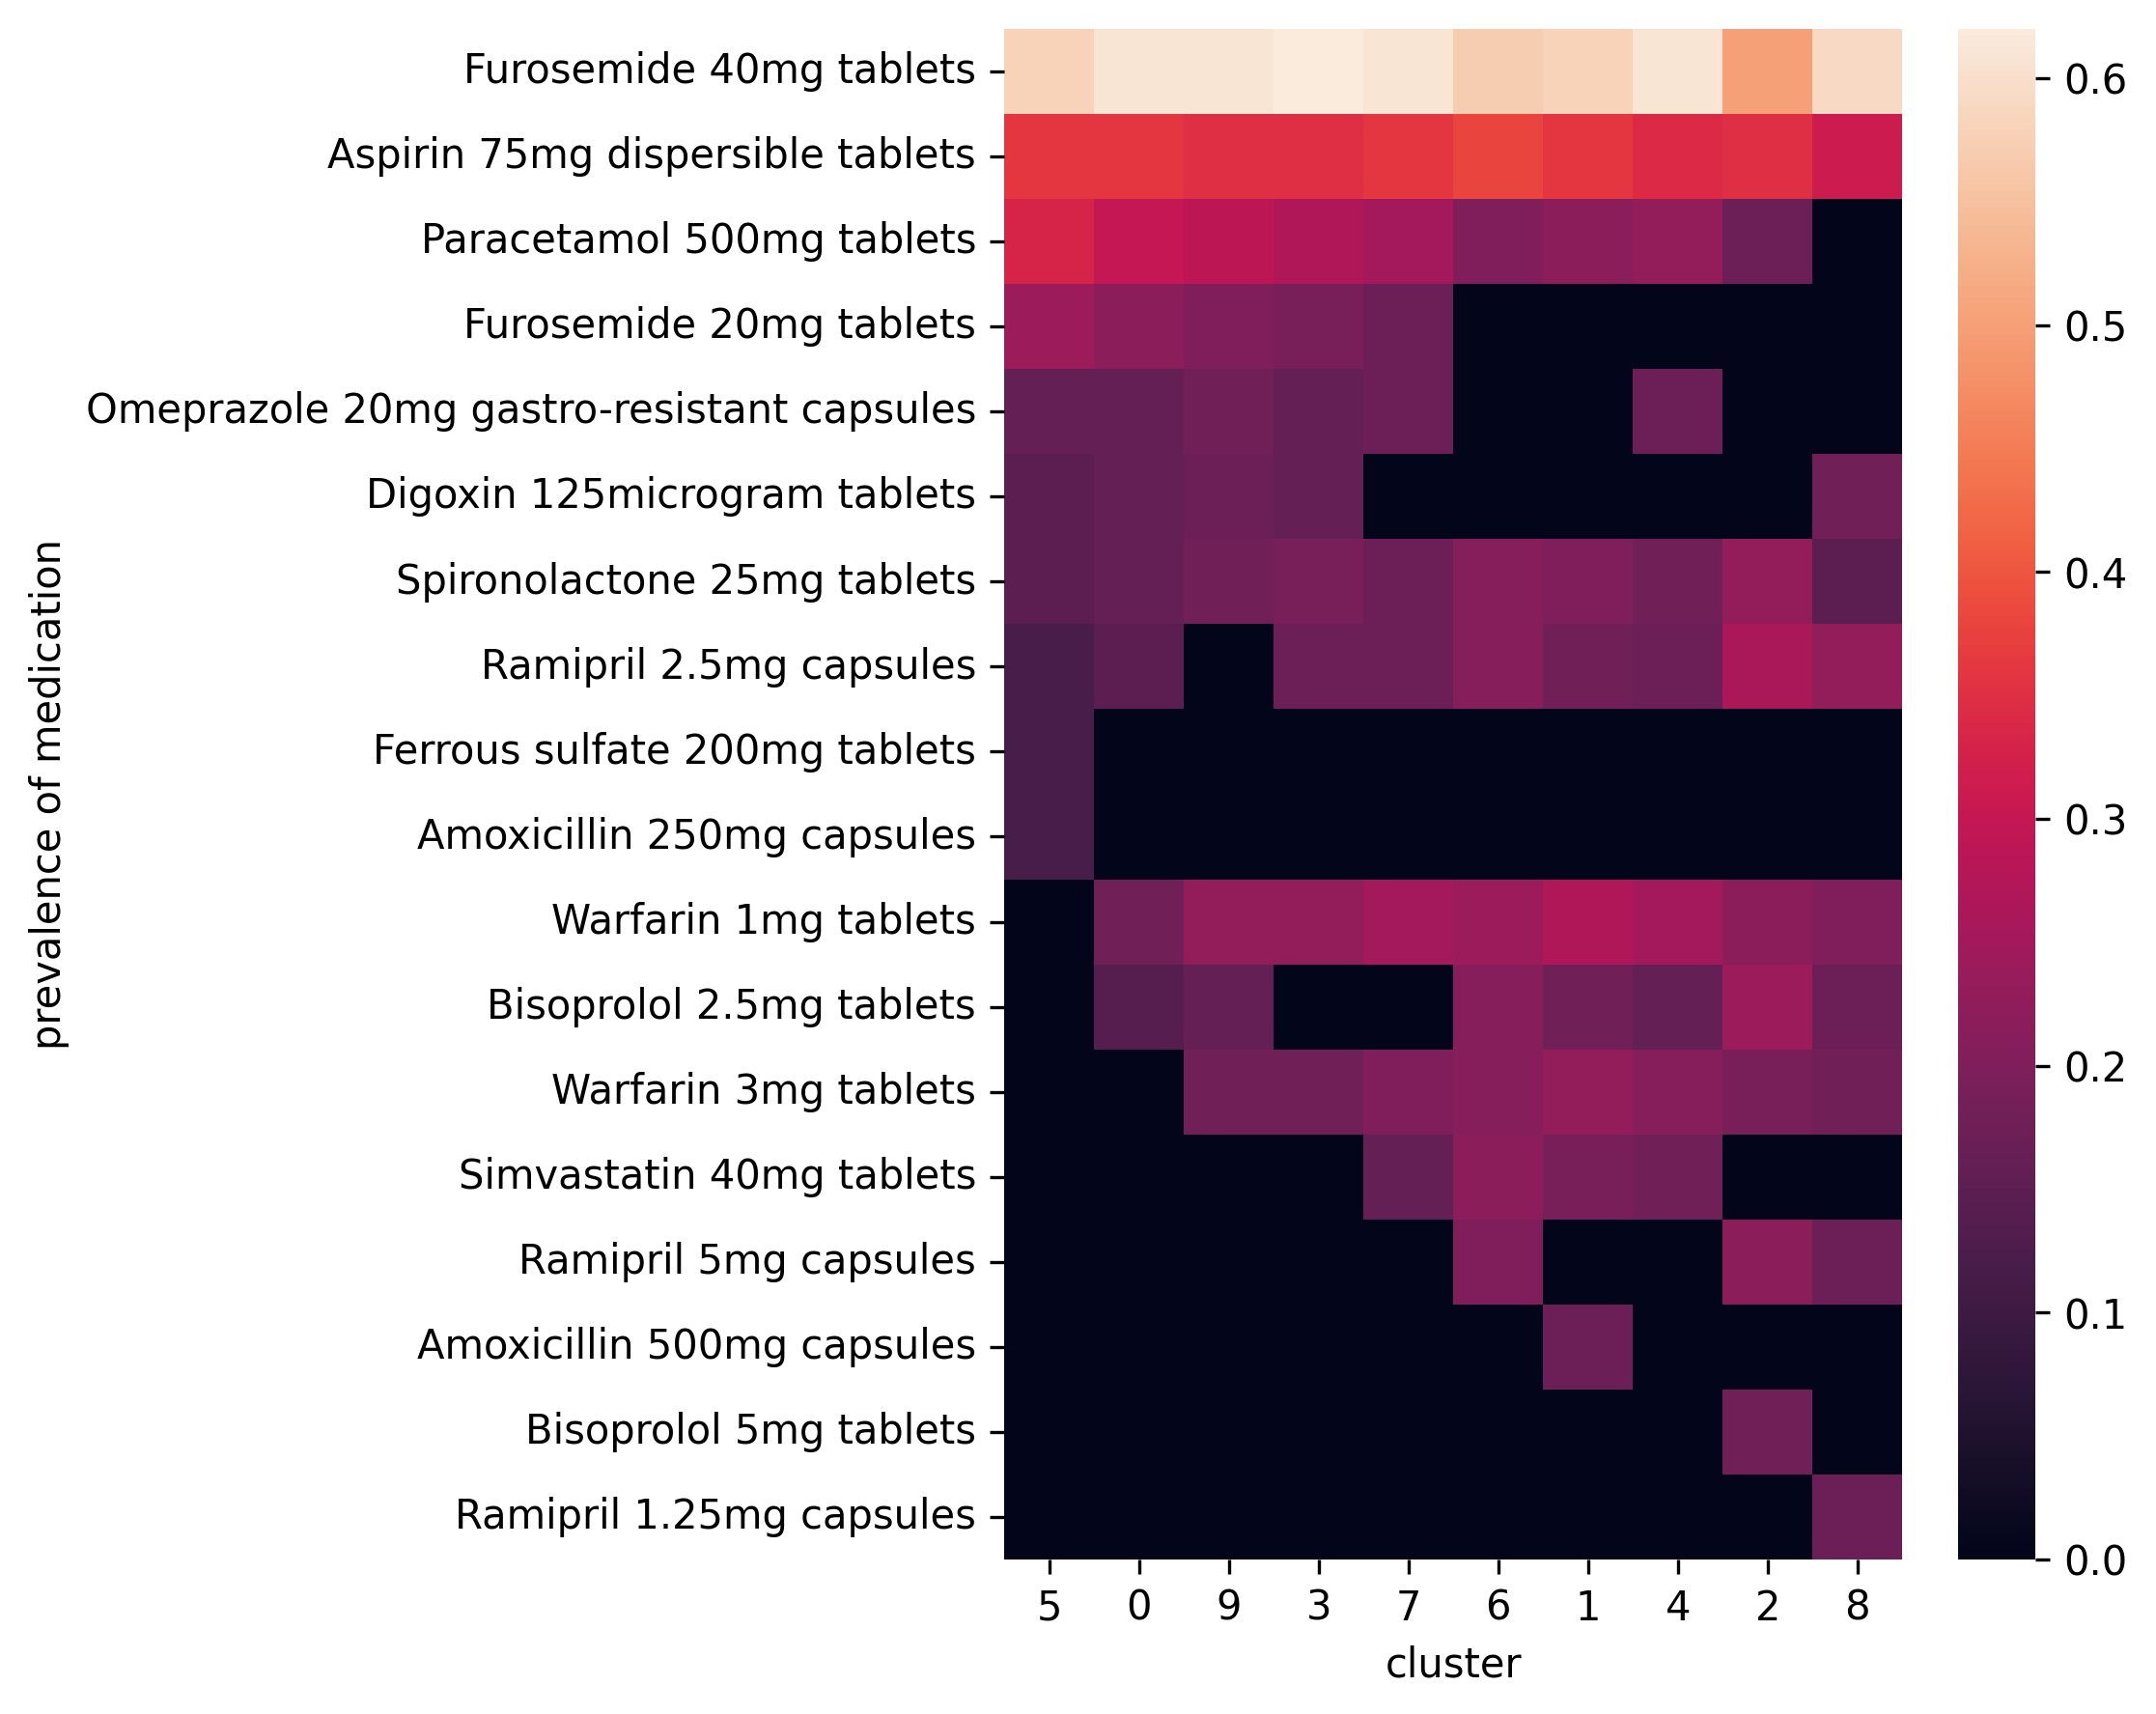

In [23]:
plt.figure(figsize=(5,7), dpi=300)
ax = sns.heatmap(med_prev)
ax.set_ylabel('prevalence of medication')
ax.set_xlabel('cluster')

In [24]:
medcode = pd.read_table('/well/rahimi/users/sev854/project/EHRPretrain/data/medical.txt', encoding='ISO-8859-1')[['medcode', 'desc']]
medcode = medcode.set_index('medcode').T.to_dict('records')[0]

In [25]:
# lab test
med_df = []

for cluster in label:
    tmp = cohort[cohort['label']==cluster]
    tmp = tmp.dropna()
    n = len(tmp) # patient number
    tmp['code'] = tmp.code.apply(lambda x: keep_identical(x, 'LAB'))
    tmp = tmp.explode('code')
    cnt = tmp.code.value_counts()
    name = [medcode[int(each)] for each in cnt.index.values]
    cnt = [round(each, 2) for each in cnt.values/n]
    top = list(zip(name[0:top_n], cnt[0:top_n]))
    med_df.append(pd.DataFrame({'cluster': [cluster], 'top lab test': [top]}))

med_df = pd.concat(med_df)
med_name = {}

for name in med_df.explode('top lab test')['top lab test'].apply(lambda x: x[0]).unique():
    med_name[name] = np.zeros(len(label))

for cluster in label:
    for name, prev in med_df[med_df['cluster']==cluster]['top lab test'].values[0]:
        med_name[name][cluster] = prev
        
med_prev = pd.DataFrame(med_name).T

In [26]:
med_prev = med_prev[label]

Text(0.5, 174.66666666666669, 'cluster')

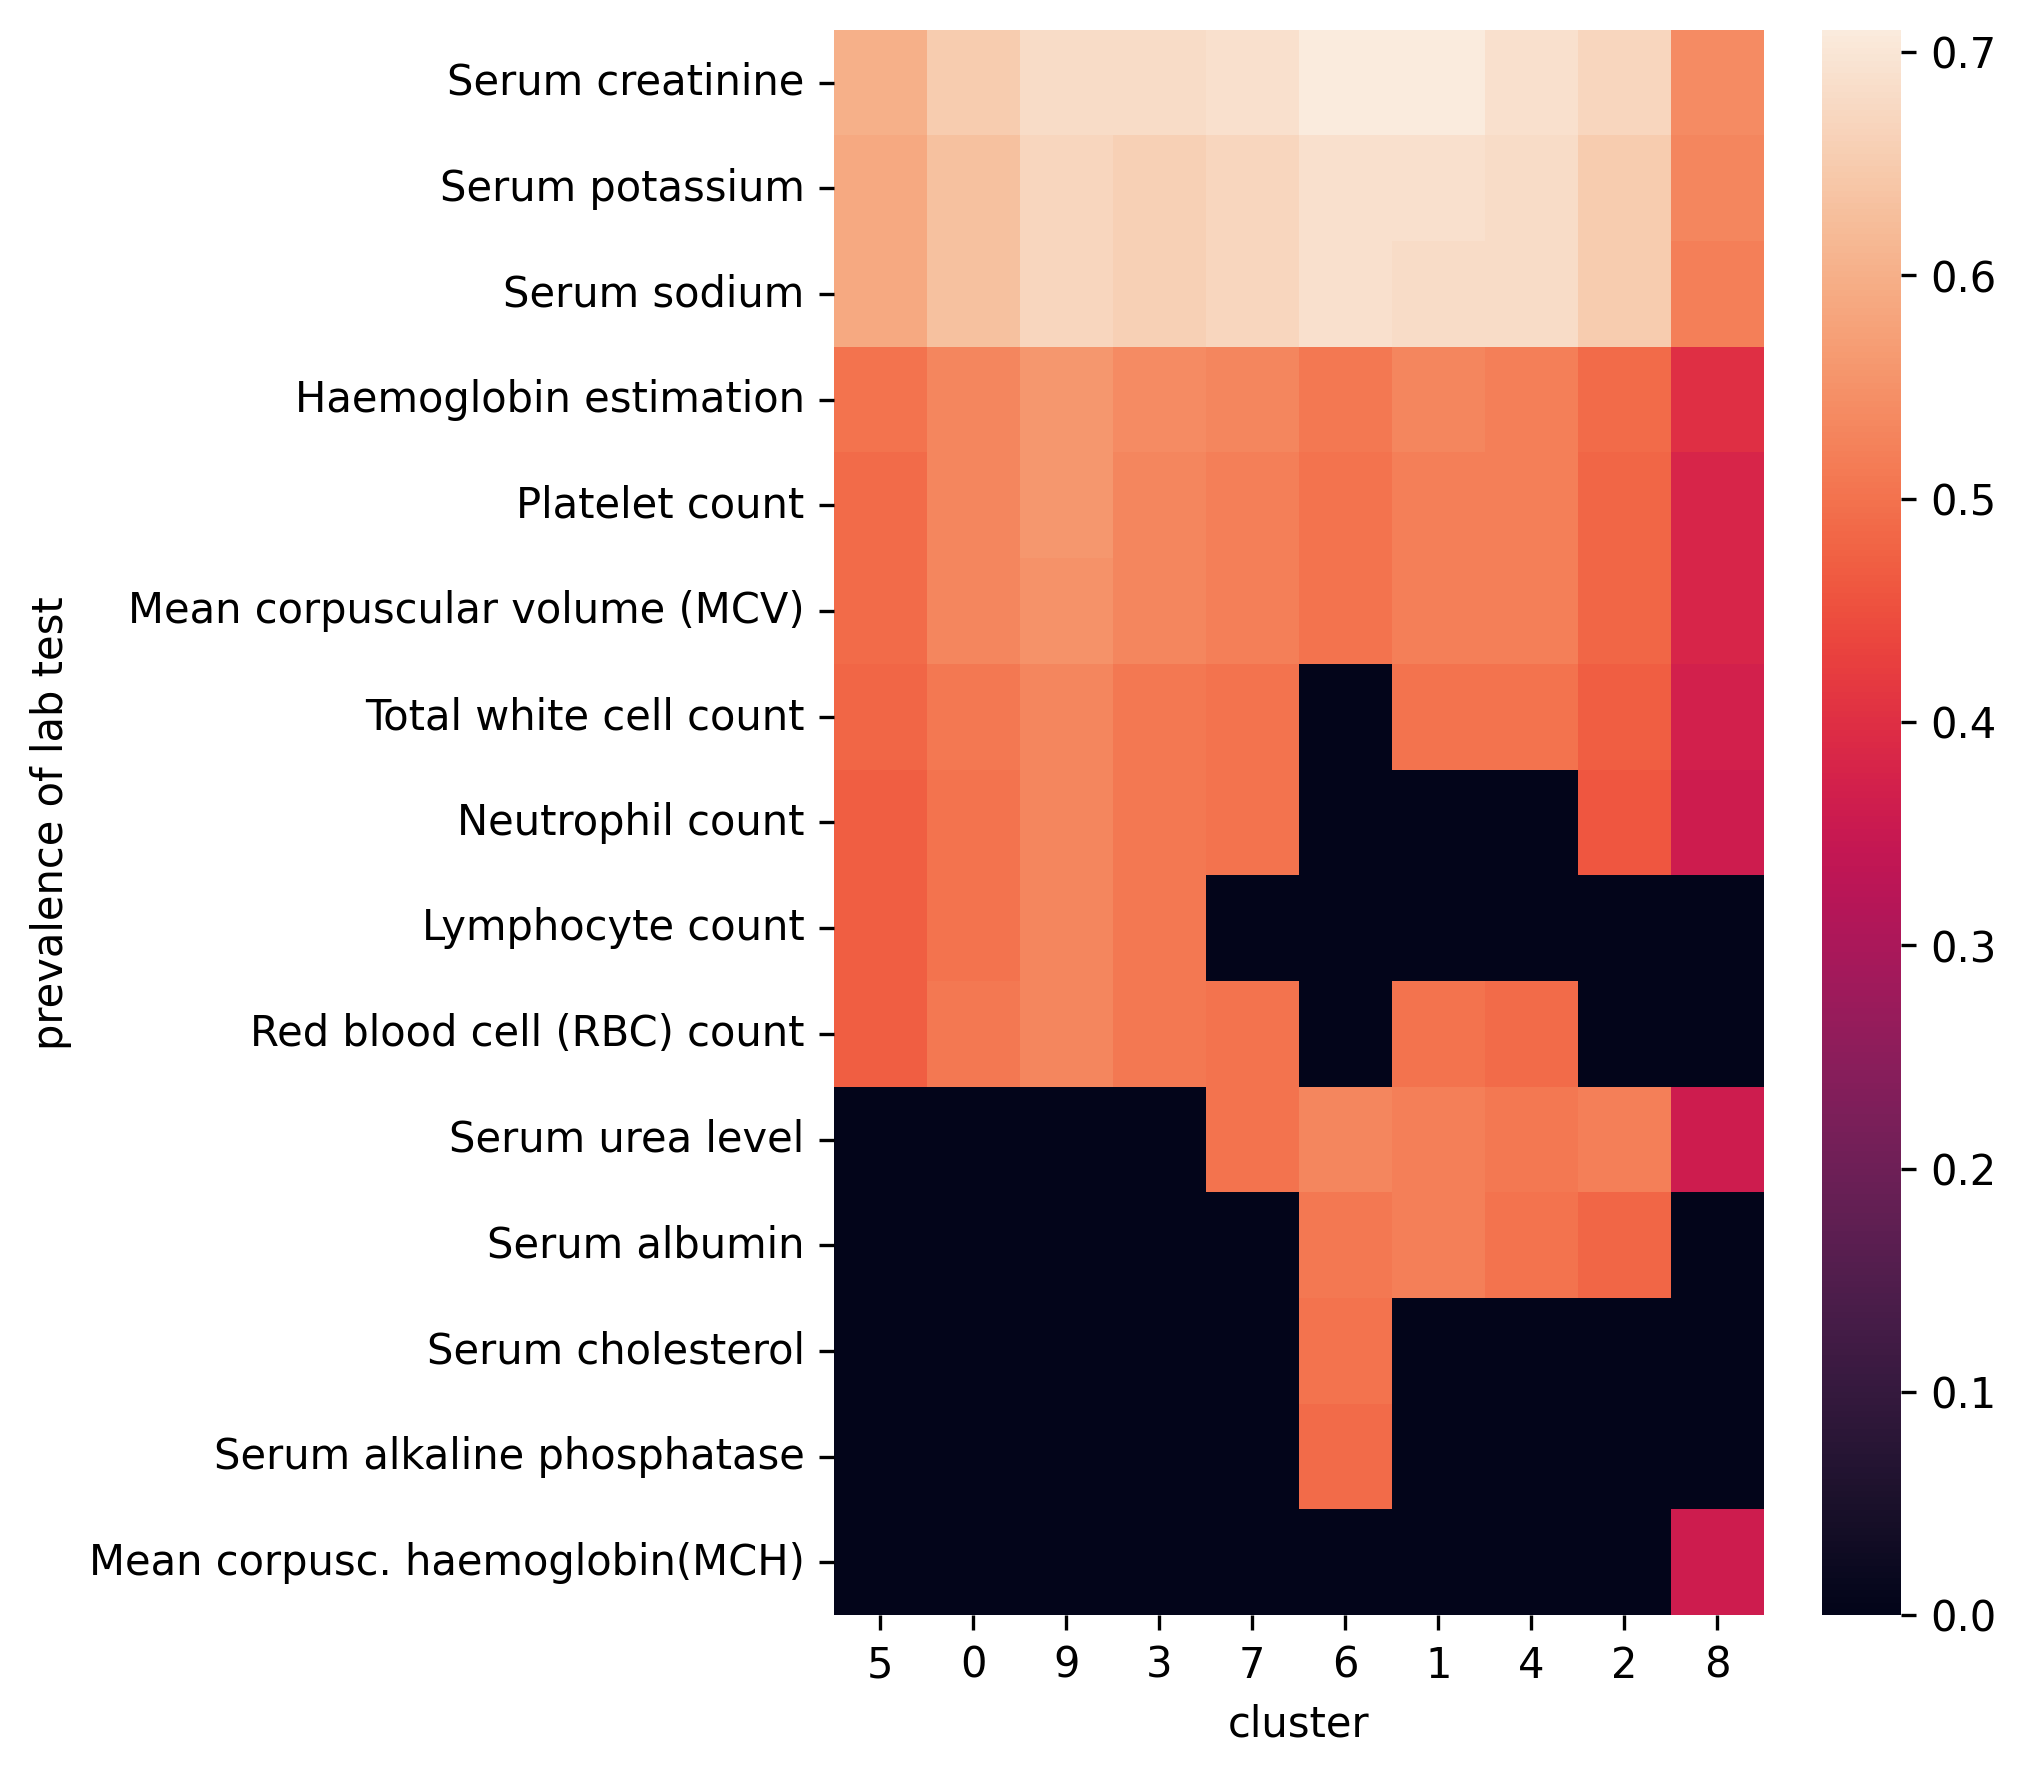

In [27]:
plt.figure(figsize=(5,7), dpi=300)
ax = sns.heatmap(med_prev)
ax.set_ylabel('prevalence of lab test')
ax.set_xlabel('cluster')

In [28]:
opcs = pd.read_table('/well/rahimi/users/sev854/project/EHRPretrain/data/opcs.txt', encoding='ISO-8859-1')[['coding', 'meaning']]
opcs = opcs.set_index('coding').T.to_dict('records')[0]

In [29]:
# procedure
med_df = []

for cluster in label:
    tmp = cohort[cohort['label']==cluster]
    tmp = tmp.dropna()
    n = len(tmp) # patient number
    tmp['code'] = tmp.code.apply(lambda x: keep_identical(x, 'PRO'))
    tmp = tmp.explode('code')
    cnt = tmp.code.value_counts()
    name = [each for each in cnt.index.values]
    cnt = [round(each, 2) for each in cnt.values/n]
    top = list(zip(name[0:top_n], cnt[0:top_n]))
    med_df.append(pd.DataFrame({'cluster': [cluster], 'top procedure': [top]}))

med_df = pd.concat(med_df)
med_name = {}

for name in med_df.explode('top procedure')['top procedure'].apply(lambda x: x[0]).unique():
    med_name[name] = np.zeros(len(label))

for cluster in label:
    for name, prev in med_df[med_df['cluster']==cluster]['top procedure'].values[0]:
        med_name[name][cluster] = prev
        
med_prev = pd.DataFrame(med_name).T
med_prev.index = [opcs[each][5:] for each in med_prev.index.values]

In [30]:
med_prev = med_prev[label]

Text(0.5, 42.0, 'cluster')

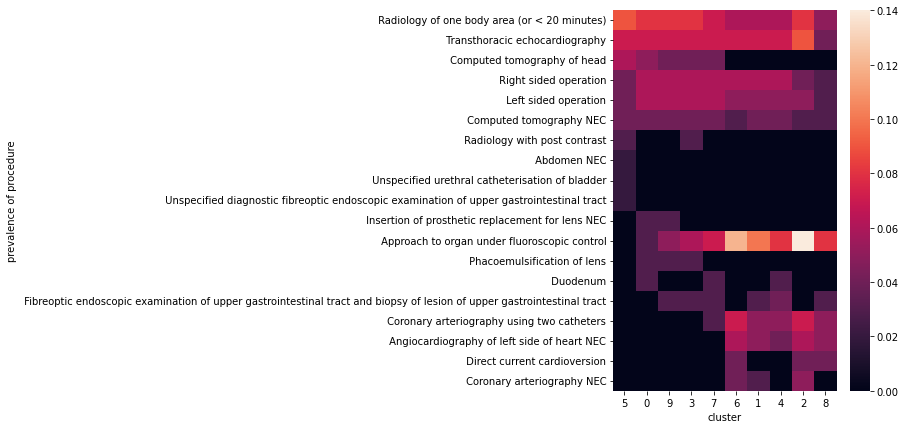

In [31]:
plt.figure(figsize=(5,7))
ax = sns.heatmap(med_prev)
ax.set_ylabel('prevalence of procedure')
ax.set_xlabel('cluster')

# Age, BMI distribution analysis

In [37]:
df = data[['patid', 'label', 'age']]
df['age'] = df.age.apply(lambda x: int(x[-1]))

/gpfs3/well/rahimi/users/sev854/install/env/projectA-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


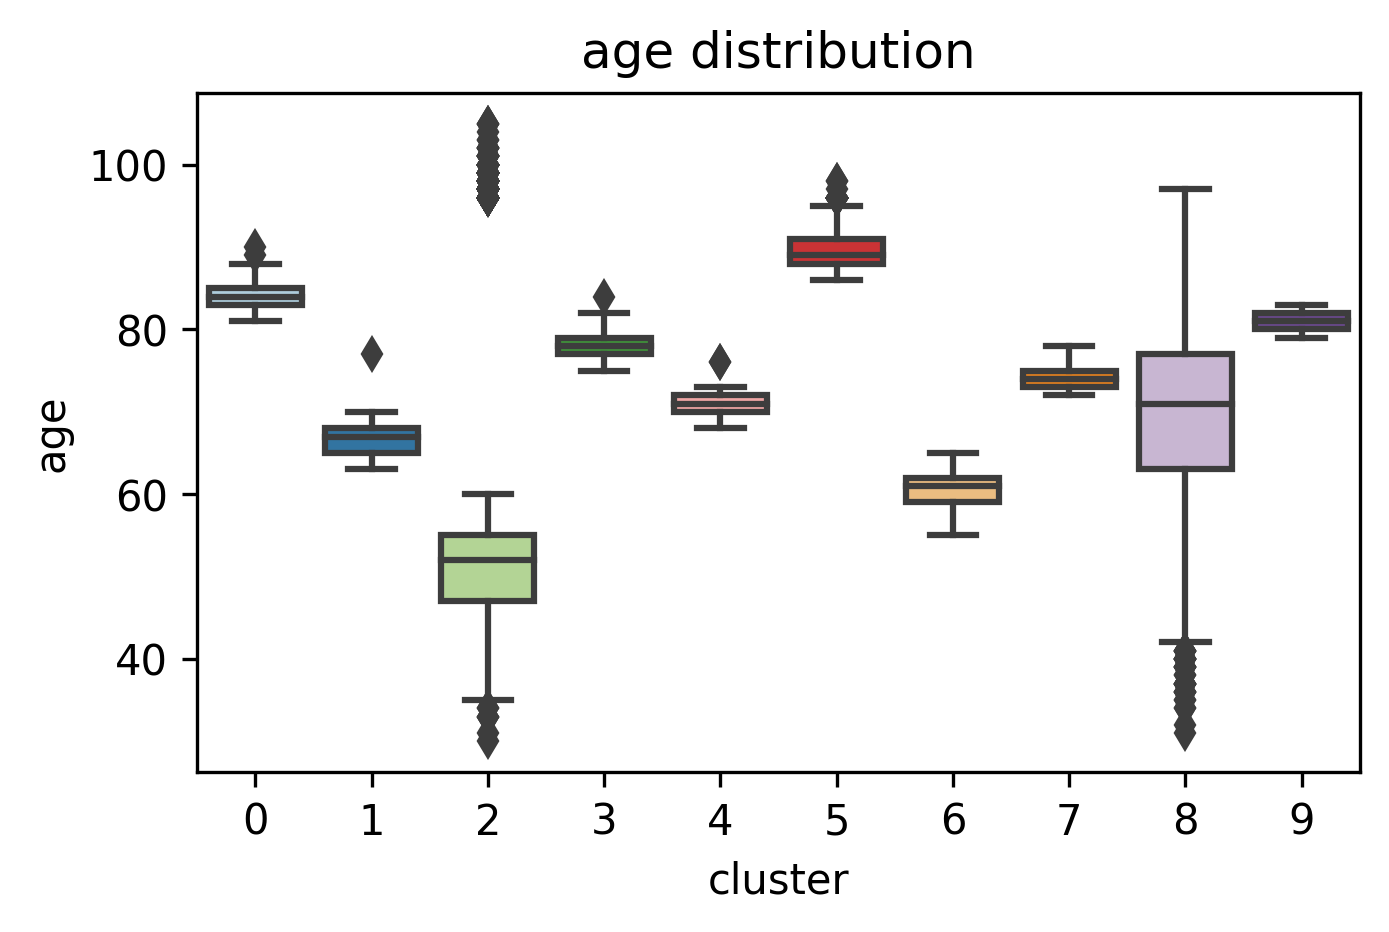

In [45]:
fig = plt.figure(figsize=(5,3), dpi=300)
ax = sns.boxplot(x="label", y="age", data=df, palette=palette)
ax.set_xlabel('cluster')
ax.set_ylabel('age')
plt.title('age distribution')
plt.show()